In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_3824106/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Raid Guild"
SPLITS_FREQ = "W-THU"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2021-12-30"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 531 non-null    object        
 1   author             531 non-null    object        
 2   date               531 non-null    datetime64[us]
 3   start              531 non-null    datetime64[us]
 4   end                393 non-null    datetime64[us]
 5   platform_proposal  531 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 25.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        1480 non-null   object        
 1   proposal  1480 non-null   object        
 2   voter     1480 non-null   object        
 3   date      1480 non-null   datetime64[us]
dtypes: d

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Raid Guild/baseline/folds-info_W-THU_normalize.parquet
fold
2023-05-04    1421
2023-05-11    1425
2023-05-18    1453
2023-05-25    1457
2023-06-01    1462
2023-06-08    1471
2023-06-15    1473
2023-06-22    1473
2023-06-29    1477
2023-07-06    1478
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W18,2,5,3,2.50,1.67,0,0,0.00,nan
2023-W19,1,0,0,0.00,nan,2,2,2.00,1.00
2023-W20,20,28,3,1.40,9.33,0,0,0.00,nan
2023-W21,3,3,1,1.00,3.00,0,0,0.00,nan
2023-W22,8,5,3,0.62,1.67,9,4,1.12,2.25
2023-W23,2,0,0,0.00,nan,2,1,1.00,2.00
2023-W24,0,0,0,nan,nan,0,0,nan,nan
2023-W25,0,0,0,nan,nan,0,0,nan,nan
2023-W26,2,3,3,1.50,1.00,0,0,0.00,nan


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W18 & 2 & 5 & 3 & 2.50 & 1.67 & 0 & 0 & 0.00 & nan \\
2023-W19 & 1 & 0 & 0 & 0.00 & nan & 2 & 2 & 2.00 & 1.00 \\
2023-W20 & 20 & 28 & 3 & 1.40 & 9.33 & 0 & 0 & 0.00 & nan \\
2023-W21 & 3 & 3 & 1 & 1.00 & 3.00 & 0 & 0 & 0.00 & nan \\
2023-W22 & 8 & 5 & 3 & 0.62 & 1.67 & 9 & 4 & 1.12 & 2.25 \\
2023-W23 & 2 & 0 & 0 & 0.00 & nan & 2 & 1 & 1.00 & 2.00 \\
2023-W24 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W25 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2023-W26 & 2 & 3 & 3 & 1.50 & 1.00 & 0 & 0 & 0.00 & nan \\
2023-W27 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
\end{tabular}



## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        if ok_in_a_row > max_ok_in_a_row[0]:
            max_ok_in_a_row = (ok_in_a_row, t)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/196 [00:00<?, ?it/s]

Warning, empty test fold 0 (2019-10-10 00:00:00), all ok since 0 folds ago
Warning, empty test fold 1 (2019-10-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 2 (2019-10-24 00:00:00), all ok since 1 folds ago
Warning, empty test fold 3 (2019-10-31 00:00:00), all ok since 1 folds ago


Warning, empty test fold 4 (2019-11-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 5 (2019-11-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 6 (2019-11-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 7 (2019-11-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 8 (2019-12-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 9 (2019-12-12 00:00:00), all ok since 1 folds ago


Warning, empty test fold 10 (2019-12-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 11 (2019-12-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 12 (2020-01-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 13 (2020-01-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 14 (2020-01-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 15 (2020-01-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 16 (2020-01-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 17 (2020-02-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 18 (2020-02-13 00:00:00), all ok since 1 folds ago
Warning, empty test fold 19 (2020-02-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 20 (2020-02-27 00:00:00), all ok since 1 folds ago
Warning, empty test fold 21 (2020-03-05 00:00:00), all ok since 1 folds ago


Warning, empty test fold 22 (2020-03-12 00:00:00), all ok since 1 folds ago
Warning, empty test fold 23 (2020-03-19 00:00:00), all ok since 1 folds ago


Warning, empty test fold 24 (2020-03-26 00:00:00), all ok since 1 folds ago
Warning, empty test fold 25 (2020-04-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 26 (2020-04-09 00:00:00), all ok since 1 folds ago
Warning, empty test fold 27 (2020-04-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 28 (2020-04-23 00:00:00), all ok since 1 folds ago
Warning, empty test fold 29 (2020-04-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 30 (2020-05-07 00:00:00), all ok since 1 folds ago
Warning, empty test fold 31 (2020-05-14 00:00:00), all ok since 1 folds ago


Warning, empty test fold 32 (2020-05-21 00:00:00), all ok since 1 folds ago
Warning, empty test fold 33 (2020-05-28 00:00:00), all ok since 1 folds ago


Warning, empty test fold 34 (2020-06-04 00:00:00), all ok since 1 folds ago
Warning, empty test fold 35 (2020-06-11 00:00:00), all ok since 1 folds ago


Warning, empty test fold 36 (2020-06-18 00:00:00), all ok since 1 folds ago
Warning, empty test fold 37 (2020-06-25 00:00:00), all ok since 1 folds ago


Warning, empty test fold 38 (2020-07-02 00:00:00), all ok since 1 folds ago
Warning, empty test fold 39 (2020-07-09 00:00:00), all ok since 1 folds ago


Warning, empty test fold 40 (2020-07-16 00:00:00), all ok since 1 folds ago
Warning, empty test fold 41 (2020-07-23 00:00:00), all ok since 1 folds ago


Warning, empty test fold 42 (2020-07-30 00:00:00), all ok since 1 folds ago
Warning, empty test fold 43 (2020-08-06 00:00:00), all ok since 1 folds ago


Warning, empty test fold 44 (2020-08-13 00:00:00), all ok since 1 folds ago
Warning, empty test fold 45 (2020-08-20 00:00:00), all ok since 1 folds ago


Warning, empty test fold 46 (2020-08-27 00:00:00), all ok since 1 folds ago
Warning, empty test fold 47 (2020-09-03 00:00:00), all ok since 1 folds ago


Warning, empty test fold 48 (2020-09-10 00:00:00), all ok since 1 folds ago
Warning, empty test fold 49 (2020-09-17 00:00:00), all ok since 1 folds ago


Warning, empty test fold 50 (2020-09-24 00:00:00), all ok since 1 folds ago
Warning, empty test fold 51 (2020-10-01 00:00:00), all ok since 1 folds ago


Warning, empty test fold 52 (2020-10-08 00:00:00), all ok since 1 folds ago
Warning, empty test fold 53 (2020-10-15 00:00:00), all ok since 1 folds ago


Warning, empty test fold 54 (2020-10-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 55 (2020-10-29 00:00:00), all ok since 1 folds ago


Warning, empty test fold 56 (2020-11-05 00:00:00), all ok since 1 folds ago
Warning, empty test fold 57 (2020-11-12 00:00:00), all ok since 1 folds ago


Warning, empty test fold 58 (2020-11-19 00:00:00), all ok since 1 folds ago
Warning, empty test fold 59 (2020-11-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 60 (2020-12-03 00:00:00), all ok since 1 folds ago
Warning, empty test fold 61 (2020-12-10 00:00:00), all ok since 1 folds ago


Warning, empty test fold 62 (2020-12-17 00:00:00), all ok since 1 folds ago
Warning, empty test fold 63 (2020-12-24 00:00:00), all ok since 1 folds ago


Warning, empty test fold 64 (2020-12-31 00:00:00), all ok since 1 folds ago
Warning, empty test fold 65 (2021-01-07 00:00:00), all ok since 1 folds ago


Warning, empty test fold 66 (2021-01-14 00:00:00), all ok since 1 folds ago
Warning, empty test fold 67 (2021-01-21 00:00:00), all ok since 1 folds ago


Warning, empty test fold 68 (2021-01-28 00:00:00), all ok since 1 folds ago
Warning, empty test fold 69 (2021-02-04 00:00:00), all ok since 1 folds ago


Warning, empty test fold 70 (2021-02-11 00:00:00), all ok since 1 folds ago
Warning, empty test fold 71 (2021-02-18 00:00:00), all ok since 1 folds ago


Warning, empty test fold 72 (2021-02-25 00:00:00), all ok since 1 folds ago
Warning, test fold 73 (2021-03-04 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 74 (2021-03-11 00:00:00), all ok since 2 folds ago
Warning, test fold 75 (2021-03-18 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 76 (2021-03-25 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 78 (2021-04-08 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, test fold 79 (2021-04-15 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 81 (2021-04-29 00:00:00) with less than 5 open proposals (3). all ok since 2 folds ago


Warning, test fold 84 (2021-05-20 00:00:00) with less than 5 open proposals (2). all ok since 3 folds ago


Warning, test fold 86 (2021-06-03 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, test fold 87 (2021-06-10 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 89 (2021-06-24 00:00:00), all ok since 15 folds ago
Warning, test fold 90 (2021-07-01 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 91 (2021-07-08 00:00:00), all ok since 2 folds ago
Warning, test fold 92 (2021-07-15 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 93 (2021-07-22 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 96 (2021-08-12 00:00:00), all ok since 5 folds ago
Warning, test fold 97 (2021-08-19 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 99 (2021-09-02 00:00:00), all ok since 3 folds ago


Warning, empty test fold 101 (2021-09-16 00:00:00), all ok since 2 folds ago
Warning, test fold 102 (2021-09-23 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 103 (2021-09-30 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 104 (2021-10-07 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 105 (2021-10-14 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 106 (2021-10-21 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 110 (2021-11-18 00:00:00), all ok since 9 folds ago
Warning, test fold 111 (2021-11-25 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 112 (2021-12-02 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 113 (2021-12-09 00:00:00), all ok since 3 folds ago


Warning, test fold 116 (2021-12-30 00:00:00) with less than 5 open proposals (2). all ok since 3 folds ago


Warning, test fold 117 (2022-01-06 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 118 (2022-01-13 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 120 (2022-01-27 00:00:00) with less than 5 open proposals (4). all ok since 2 folds ago


Warning, test fold 121 (2022-02-03 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 124 (2022-02-24 00:00:00) with less than 5 open proposals (2). all ok since 3 folds ago


Warning, empty test fold 125 (2022-03-03 00:00:00), all ok since 12 folds ago


Warning, empty test fold 127 (2022-03-17 00:00:00), all ok since 2 folds ago
Warning, test fold 128 (2022-03-24 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 129 (2022-03-31 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago
Warning, test fold 130 (2022-04-07 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 131 (2022-04-14 00:00:00), all ok since 4 folds ago
Warning, test fold 132 (2022-04-21 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 133 (2022-04-28 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 134 (2022-05-05 00:00:00), all ok since 3 folds ago


Warning, test fold 136 (2022-05-19 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, empty test fold 137 (2022-05-26 00:00:00), all ok since 3 folds ago
Warning, empty test fold 138 (2022-06-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 139 (2022-06-09 00:00:00), all ok since 1 folds ago
Warning, empty test fold 140 (2022-06-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 141 (2022-06-23 00:00:00), all ok since 1 folds ago
Warning, empty test fold 142 (2022-06-30 00:00:00), all ok since 1 folds ago


Warning, test fold 143 (2022-07-07 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 146 (2022-07-28 00:00:00) with less than 5 open proposals (1). all ok since 3 folds ago
Warning, test fold 147 (2022-08-04 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 148 (2022-08-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 149 (2022-08-18 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 150 (2022-08-25 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 151 (2022-09-01 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 152 (2022-09-08 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 153 (2022-09-15 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 154 (2022-09-22 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 155 (2022-09-29 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 156 (2022-10-06 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 157 (2022-10-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 158 (2022-10-20 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 159 (2022-10-27 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 160 (2022-11-03 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 161 (2022-11-10 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 162 (2022-11-17 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 163 (2022-11-24 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 164 (2022-12-01 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 165 (2022-12-08 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 166 (2022-12-15 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 167 (2022-12-22 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 168 (2022-12-29 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 169 (2023-01-05 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 170 (2023-01-12 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 171 (2023-01-19 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 172 (2023-01-26 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, test fold 173 (2023-02-02 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 174 (2023-02-09 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 175 (2023-02-16 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 176 (2023-02-23 00:00:00), all ok since 34 folds ago
Warning, empty test fold 177 (2023-03-02 00:00:00), all ok since 1 folds ago


Warning, empty test fold 178 (2023-03-09 00:00:00), all ok since 1 folds ago
Warning, empty test fold 179 (2023-03-16 00:00:00), all ok since 1 folds ago


Warning, empty test fold 180 (2023-03-23 00:00:00), all ok since 1 folds ago
Warning, empty test fold 181 (2023-03-30 00:00:00), all ok since 1 folds ago


Warning, empty test fold 182 (2023-04-06 00:00:00), all ok since 1 folds ago
Warning, test fold 183 (2023-04-13 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 184 (2023-04-20 00:00:00), all ok since 2 folds ago
Warning, test fold 185 (2023-04-27 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 186 (2023-05-04 00:00:00), all ok since 2 folds ago
Warning, test fold 187 (2023-05-11 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 188 (2023-05-18 00:00:00), all ok since 2 folds ago
Warning, empty test fold 189 (2023-05-25 00:00:00), all ok since 1 folds ago


Warning, test fold 191 (2023-06-08 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago
Warning, empty test fold 192 (2023-06-15 00:00:00), all ok since 3 folds ago


Warning, empty test fold 193 (2023-06-22 00:00:00), all ok since 1 folds ago
Warning, empty test fold 194 (2023-06-29 00:00:00), all ok since 1 folds ago


Max ok in a row: (34, Timestamp('2023-02-23 00:00:00'))


Warning, empty test fold 195 (2023-07-06 00:00:00), all ok since 1 folds ago


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Raid Guild/baseline/openpop_W-THU_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,...,196.000000,196.000000,196.000000,196.000000,191.000000,190.000000,190.000000,190.000000,190.000000,196.000000
mean,0.134437,0.084325,0.057199,0.029008,0.019339,0.002901,0.124658,0.152209,0.157969,0.158526,...,0.197648,0.197648,0.197648,0.150260,0.187867,0.194548,0.194548,0.194548,0.194548,0.084639
std,0.304600,0.161782,0.107854,0.055214,0.036809,0.005521,0.284562,0.302731,0.308153,0.309091,...,0.365518,0.365518,0.365518,0.323459,0.361197,0.370387,0.370387,0.370387,0.370387,0.022230
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068149
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069312
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070992
75%,0.000000,0.011905,0.030519,0.015260,0.010173,0.001526,0.000000,0.021331,0.085484,0.085484,...,0.076705,0.076705,0.076705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111395
max,1.000000,0.833333,0.500000,0.250000,0.166667,0.025000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.127793


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Raid Guild/baseline/perfect_W-THU_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,...,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000
mean,0.459184,0.192205,0.119286,0.059771,0.039847,0.005977,0.459184,0.459184,0.459184,0.459184,...,0.459184,0.459184,0.459184,0.409253,0.454744,0.459001,0.459184,0.459184,0.459184,0.097847
std,0.499607,0.225256,0.144242,0.072547,0.048365,0.007255,0.499607,0.499607,0.499607,0.499607,...,0.499607,0.499607,0.499607,0.456963,0.495222,0.499416,0.499607,0.499607,0.499607,0.029503
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071790
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072982
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.075155
75%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.124009
max,1.000000,0.777778,0.600000,0.312500,0.208333,0.031250,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.296639


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,196,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,...,196.000000,196.000000,191.000000,190.000000,190.000000,190.000000,190.000000,196.000000,0.0,0.0
mean,2021-08-22 12:00:00,0.134437,0.084325,0.057199,0.029008,0.019339,0.002901,0.124658,0.152209,0.157969,...,0.197648,0.150260,0.187867,0.194548,0.194548,0.194548,0.194548,0.084639,NaN,NaN
min,2019-10-10 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068149,NaN,NaN
25%,2020-09-15 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069312,NaN,NaN
50%,2021-08-22 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070992,NaN,NaN
75%,2022-07-29 18:00:00,0.000000,0.011905,0.030519,0.015260,0.010173,0.001526,0.000000,0.021331,0.085484,...,0.076705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111395,NaN,NaN
max,2023-07-06 00:00:00,1.000000,0.833333,0.500000,0.250000,0.166667,0.025000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.127793,NaN,NaN
std,NaN,0.304600,0.161782,0.107854,0.055214,0.036809,0.005521,0.284562,0.302731,0.308153,...,0.365518,0.323459,0.361197,0.370387,0.370387,0.370387,0.370387,0.022230,NaN,NaN


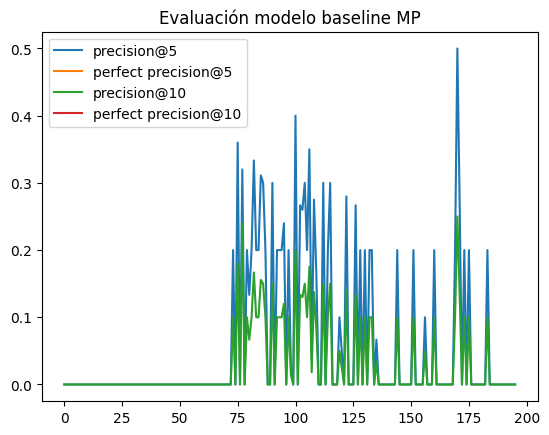

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.000000,0.0,0.0
mean,2023-06-04 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071666,NaN,NaN
min,2023-05-04 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069692,NaN,NaN
25%,2023-05-19 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069826,NaN,NaN
50%,2023-06-04 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070083,NaN,NaN
75%,2023-06-20 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071546,NaN,NaN
max,2023-07-06 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082569,NaN,NaN
std,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003931,NaN,NaN
